# Part 3 – SUBMISSION.tsv Exploratory Data Analysis & Summary

This notebook analyzes **SUBMISSION.tsv**, with a focus on:
- Basic structure and key fields (e.g., `ACCESSION_NUMBER`, `CIK`, `PERIOD_OF_REPORT`)
- Unique filers and filing activity
- Presence/absence of **Rule 10b5-1 trading plans** (if a corresponding field exists)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Load data
Update `SUBMISSION_PATH` as needed for your environment.

In [3]:
SUBMISSION_PATH = r"/Users/aaniaadap/Desktop/KDDM Project/Dataset/SUBMISSION.tsv"  # <-- update this

df_submission = pd.read_csv(SUBMISSION_PATH, sep='\t', low_memory=False)
df_submission.head()

,ACCESSION_NUMBER,FILING_DATE,PERIOD_OF_REPORT,DATE_OF_ORIG_SUB,NO_SECURITIES_OWNED,NOT_SUBJECT_SEC16,FORM3_HOLDINGS_REPORTED,FORM4_TRANS_REPORTED,DOCUMENT_TYPE,ISSUERCIK,ISSUERNAME,ISSUERTRADINGSYMBOL,REMARKS,AFF10B5ONE
0,0001104659-25-030099,31-MAR-2025,31-MAR-2025,NaN,NaN,0,NaN,NaN,4,1840502,Taboola.com Ltd.,TBLA,NaN,0
1,0001127602-25-010616,31-MAR-2025,27-MAR-2025,NaN,NaN,NaN,NaN,NaN,4,920148,LABCORP HOLDINGS INC.,LH,NaN,0
2,0001451809-25-000066,31-MAR-2025,27-MAR-2025,NaN,NaN,0,NaN,NaN,4,1451809,SITIME Corp,SITM,NaN,0
3,0001805077-25-000039,31-MAR-2025,26-MAR-2025,NaN,1.0,NaN,NaN,NaN,3,1805077,"Eos Energy Enterprises, Inc.",EOSE,NaN,NaN
4,0000905148-25-001026,31-MAR-2025,19-MAR-2025,21-MAR-2025,NaN,NaN,NaN,NaN,4/A,1018164,WILLIS LEASE FINANCE CORP,WLFC,This amendment to the Form 4 filed by the Repo...,false


## Basic info and missing values
We inspect dimensions, data types, and missingness to understand submission-level data quality.

In [4]:
print('Shape:', df_submission.shape)
df_submission.dtypes

Shape: (63284, 14)


ACCESSION_NUMBER            object
FILING_DATE                 object
PERIOD_OF_REPORT            object
DATE_OF_ORIG_SUB            object
NO_SECURITIES_OWNED        float64
NOT_SUBJECT_SEC16           object
FORM3_HOLDINGS_REPORTED    float64
FORM4_TRANS_REPORTED       float64
DOCUMENT_TYPE               object
ISSUERCIK                    int64
ISSUERNAME                  object
ISSUERTRADINGSYMBOL         object
REMARKS                     object
AFF10B5ONE                  object
dtype: object

In [5]:
missing = df_submission.isnull().sum()
missing_pct = (missing / len(df_submission) * 100).round(2)
pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})

,Missing Count,Missing %
ACCESSION_NUMBER,0,0.00
FILING_DATE,0,0.00
PERIOD_OF_REPORT,0,0.00
DATE_OF_ORIG_SUB,62123,98.17
NO_SECURITIES_OWNED,59864,94.60
NOT_SUBJECT_SEC16,30687,48.49
FORM3_HOLDINGS_REPORTED,62213,98.31
FORM4_TRANS_REPORTED,62213,98.31
DOCUMENT_TYPE,0,0.00
ISSUERCIK,0,0.00


## Filing activity overview
We examine key identifiers such as `CIK` and filing dates to understand how active different filers are.

In [6]:
if 'CIK' in df_submission.columns:
    unique_ciks = df_submission['CIK'].nunique()
    print('Unique CIKs:', unique_ciks)
    top_ciks = df_submission['CIK'].value_counts().head(10)
    display(top_ciks)

if 'PERIOD_OF_REPORT' in df_submission.columns:
    df_submission['PERIOD_OF_REPORT'] = pd.to_datetime(df_submission['PERIOD_OF_REPORT'], errors='coerce')
    filings_by_year = df_submission['PERIOD_OF_REPORT'].dt.year.value_counts().sort_index()
    display(filings_by_year)

PERIOD_OF_REPORT
2003        1
2011        1
2013        1
2014        5
2015        3
2016        1
2017        5
2018        4
2019        3
2020        8
2021       28
2022       38
2023      154
2024     4216
2025    58816
Name: count, dtype: int64

**PERIOD_OF_REPORT ≠ filing date.** 
- It refers to the actual period the transaction occurred, not when the filing was submitted. So a form filed in early 2025 can still report insider trades that happened in late 2024 or earlier.

**Back-dated or amended filings.** 
- Companies sometimes file amendments or delayed disclosures (Form 4/A, Form 5) that reference older transaction periods, which explains 2023 or 2024 dates.

**Carry-over data from merged sources.** 
- If your dataset combines multiple SEC feeds (non-derivative, derivative, reporting-owner files), older report periods can appear even though the data was extracted during 2025 Q1.

In [8]:
df_submission['PERIOD_OF_REPORT'].value_counts().sort_index()

PERIOD_OF_REPORT
2003-11-03      1
2011-07-26      1
2013-09-01      1
2014-09-04      1
2014-12-29      3
             ... 
2025-03-27    361
2025-03-28    157
2025-03-29      7
2025-03-30     10
2025-03-31     77
Name: count, Length: 483, dtype: int64

In [11]:
import re

def detect_format(val):
    s = str(val).strip()
    if re.fullmatch(r"\d{4}", s):
        return "YYYY"
    if re.fullmatch(r"\d{4}-\d{2}-\d{2}", s):
        return "YYYY-MM-DD"
    if re.fullmatch(r"\d{2}/\d{2}/\d{4}", s):
        return "MM/DD/YYYY"
    if re.fullmatch(r"\d{2}-\d{2}-\d{4}", s):
        return "DD-MM-YYYY"
    if re.fullmatch(r"\d{8}", s):
        return "YYYYMMDD"
    return "OTHER/WEIRD"

df_submission["POR_format"] = df_submission["PERIOD_OF_REPORT"].apply(detect_format)

print(df_submission["POR_format"].value_counts(dropna=False))
print(df_submission[df_submission["POR_format"] == "OTHER/WEIRD"]["PERIOD_OF_REPORT"].unique()[:50])


POR_format
OTHER/WEIRD    63284
Name: count, dtype: int64
<DatetimeArray>
['2025-03-31 00:00:00', '2025-03-27 00:00:00', '2025-03-26 00:00:00',
 '2025-03-19 00:00:00', '2025-03-28 00:00:00', '2025-03-29 00:00:00',
 '2025-02-14 00:00:00', '2025-03-21 00:00:00', '2021-12-30 00:00:00',
 '2025-03-30 00:00:00', '2025-03-20 00:00:00', '2023-07-11 00:00:00',
 '2025-03-12 00:00:00', '2024-05-02 00:00:00', '2025-03-25 00:00:00',
 '2021-10-14 00:00:00', '2025-03-16 00:00:00', '2021-09-30 00:00:00',
 '2025-03-18 00:00:00', '2024-07-11 00:00:00', '2025-03-07 00:00:00',
 '2024-07-30 00:00:00', '2017-03-03 00:00:00', '2023-12-31 00:00:00',
 '2024-11-14 00:00:00', '2019-12-19 00:00:00', '2024-01-04 00:00:00',
 '2025-03-15 00:00:00', '2025-03-13 00:00:00', '2024-09-25 00:00:00',
 '2023-03-15 00:00:00', '2024-04-01 00:00:00', '2023-12-21 00:00:00',
 '2025-03-03 00:00:00', '2025-01-29 00:00:00', '2025-01-30 00:00:00',
 '2025-01-23 00:00:00', '2024-12-31 00:00:00', '2025-01-31 00:00:00',
 '2025-01-15 00:

In [13]:
# Number of unique report dates in 2025
df_submission['PERIOD_OF_REPORT'].dt.year.value_counts().sort_index()

# How many unique 2025 report dates exist
df_2025 = df_submission[df_submission['PERIOD_OF_REPORT'].dt.year == 2025]
print("Unique dates in 2025:", df_2025['PERIOD_OF_REPORT'].nunique())

# Top 10 most frequent report dates
print(df_2025['PERIOD_OF_REPORT'].value_counts().head(10))


Unique dates in 2025: 90
PERIOD_OF_REPORT
2025-01-02    2522
2025-03-03    2090
2025-02-28    1973
2025-03-01    1723
2025-02-18    1636
2025-01-31    1380
2025-01-01    1356
2025-02-20    1294
2025-02-14    1265
2025-02-24    1255
Name: count, dtype: int64


- The PERIOD_OF_REPORT column is in a valid datetime format — there are no formatting or parsing errors.

- The data for 2025 covers only Q1, with 90 unique report dates in total.

- Filings are heavily concentrated on a few specific dates — e.g., Jan 2 (2522), Mar 3 (2090), and Feb 28 (1973) — which is unusually high for typical insider trading volumes.

- This suggests that the spike in 2025 filings is not due to increased activity, but rather repeated or expanded entries in the dataset.

- The duplication likely comes from multiple transaction-level rows per filing (e.g., one per security, derivative, or issuer), or merged data sources causing repetition.

- Therefore, the 2025 Q1 surge represents data duplication or reporting granularity, not an actual rise in insider trading.

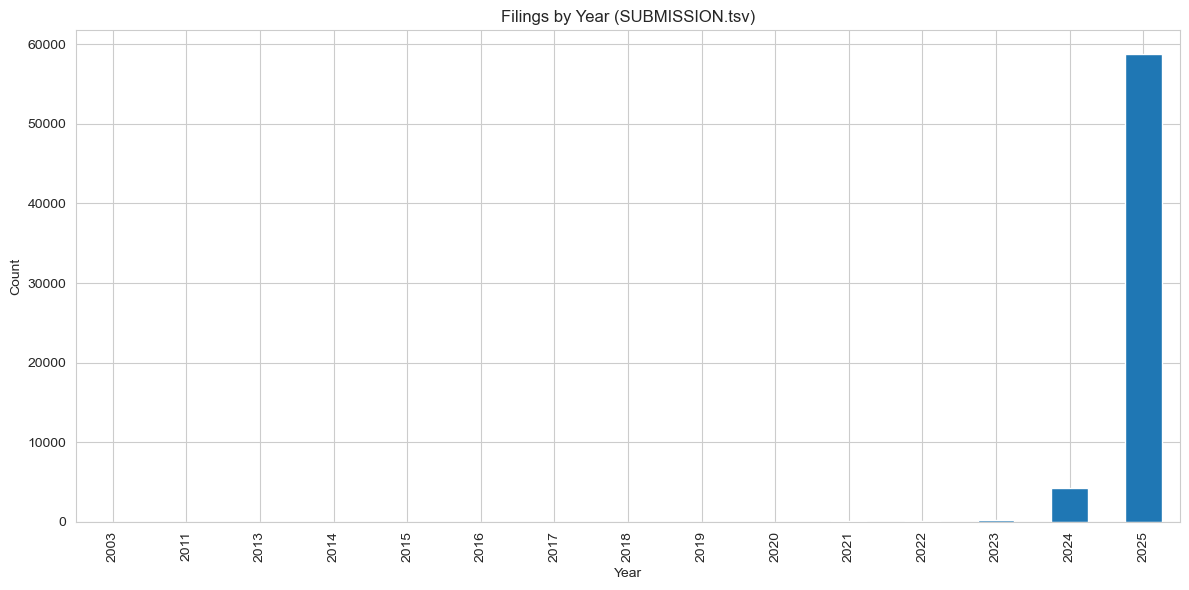

In [7]:
if 'PERIOD_OF_REPORT' in df_submission.columns:
    plt.figure()
    df_submission['PERIOD_OF_REPORT'].dt.year.value_counts().sort_index().plot(kind='bar')
    plt.title('Filings by Year (SUBMISSION.tsv)')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## 4. 10b5-1 plan indicator (if available)
If the dataset contains a column indicating Rule 10b5-1 trading plans (e.g., `IS_10B5_1` or similar), we can compute the share of filings with vs. without such a plan.

In [8]:
plan_cols = [c for c in df_submission.columns if '10b5' in c.lower() or '10b5-1' in c.lower()]
plan_cols

['AFF10B5ONE']

Using column as 10b5-1 indicator: AFF10B5ONE


AFF10B5ONE
0        42850
false    12072
1         3687
NaN       3420
true      1255
Name: count, dtype: int64

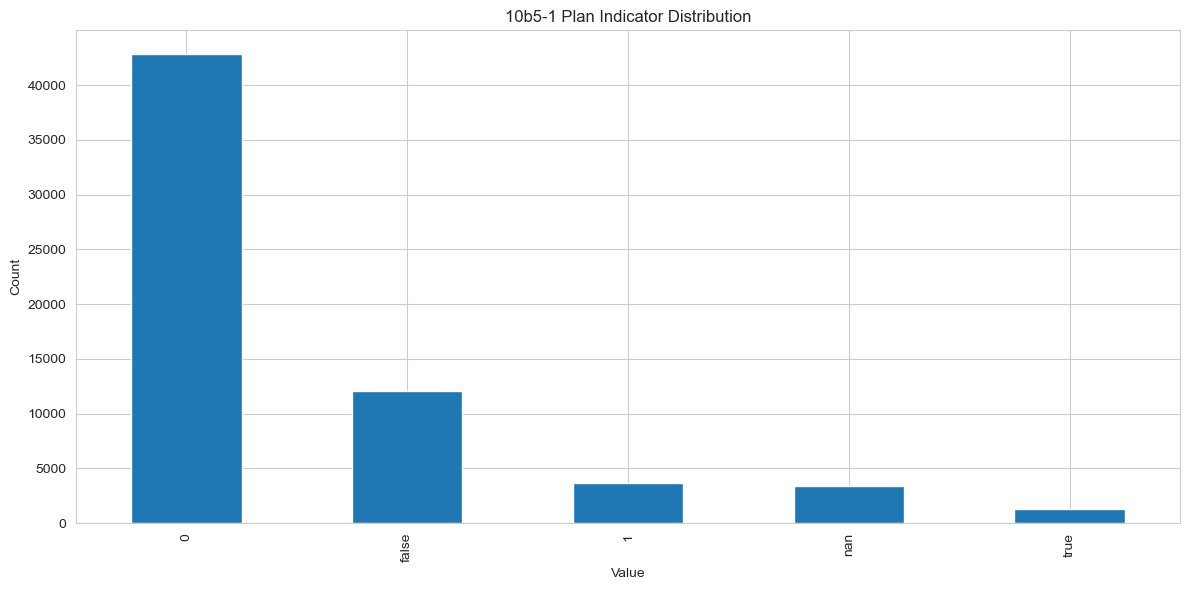

In [9]:
if plan_cols:
    col = plan_cols[0]
    print('Using column as 10b5-1 indicator:', col)
    value_counts = df_submission[col].value_counts(dropna=False)
    display(value_counts)

    plt.figure()
    value_counts.plot(kind='bar')
    plt.title('10b5-1 Plan Indicator Distribution')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('No explicit 10b5-1 indicator column detected.')

## 5. Combined high-level summary
- **NONDERIV_TRANS.tsv**: Transaction-level data (buy/sell, shares, prices, dollar values) for common stock insider trades.
- **REPORTINGOWNER.tsv**: Describes who the reporters are and their roles (officers, directors, large owners).
- **SUBMISSION.tsv**: Captures filing-level metadata, linking transactions and owners at the form level.
